# Convolution Neural Nets using Pytorch

Convolutions are considerably old yet still valid ML technique used in Machine Vision related Deep Learning space. I am not going to theories, but basically we consider number of windows (kernals) to train on the provided data. This is very useful in Image related tasks as images have spacial(locality) features.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plot

In [2]:
from torchvision import datasets
from torchvision import transforms

data_path = "datasets/"

In [3]:
cifar10_tensors_t = datasets.CIFAR10( data_path, 
                                    train=True, 
                                    download=False, 
                                    transform=
                                        transforms.Compose([
                                            transforms.ToTensor()
                                        ]))

In [4]:
cifar10_tensors_val_t = datasets.CIFAR10( data_path, 
                                    train=False, 
                                    download=False, 
                                    transform=
                                        transforms.Compose([
                                            transforms.ToTensor()
                                        ]))

In [5]:
cifar_birdplane = [(img, min(label, 1))
                        for img, label in cifar10_tensors_t
                                if label in [0, 2]]

cifar_birdplane_val = [(img, min(label, 1))
                        for img, label in cifar10_tensors_val_t
                            if label in [0, 2]]

Since we now have the dataset, lets look in to the Convolution network building using pytorch. As we know tensorflow convolution network are super easy to use. They have a class type in which we can define num of kernals and other kernal related parameters (if needed input dimensions).

Pytorch also has similar structure, but as developer we need to define the dimesional values along with all the other parameters(kernal size, stride, output shape etc). This is good for learning and research purposes, but kinda less intuitive for well defined usecase IMO(means tensorflow is easier to use). Anyhow sample usage is as follows.

In [6]:
import torch.nn as nn

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

Here first parameter value is input feature channel (depth) size. In RGB images we have 3 channels, so convolutional channel should have value 3 for that. Next is out channel size. We can define this to our requirement.

So now we have 16, 3x3 size kernals to process 3 input channels which means this layer should have 3x3x3x16 weight parameters with another 16 bias values.

In [8]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

Below, shows the dimensions of output image. typical stuff. In tensorflow, nearby layers can automatically calculate input parameters (except in the start) when defined in chained fashion. But in pytorch we need to define input shapes for all layers. (Which is bit annoying!) So we need to keep track of layer output shapes.

In [9]:
img, _ = cifar_birdplane[0]
convoluted_img = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, convoluted_img.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We can plot the convoluted image like below. Here `detach` is required because pytorch tries to calculate gradient map (graph building) for that function, which may cause problems.

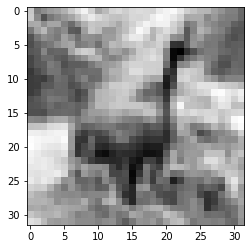

In [14]:
plot.imshow(img[0], cmap='gray')
plot.show()

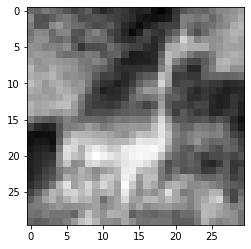

In [12]:
plot.imshow(convoluted_img[0, 0].detach(), cmap='gray')
plot.show()

Also we are given with other parameters like padding to adjust the sizes of the output as usual.

Lets revert back the weight values and biases for the next step.

In [15]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

Before going to implementation, there's another important note to be understand. That is in convolution networks, we have translational invariant and locality invariant. Since convoltional kernals move it provides translational invariant to some extent. But not locality invariant. Most of the features in different images differ in their location and their sizes. To fix this issue we can use a kernal with the full width of original image. But then we loose the computational advantage because of the large number of processing we have to do.

> It should be noted, above claims are paraphrased from the book I am referring. Stacking layers is effective and there are no arguments against it, but whether it provides locality invariance I am not sure. Reason is after each convolution we get slightly different image(matrix) to process, and I am not sure how they do claim locality invariance is preserved by stacking and downsampling such different images. Nevertherless interpretation is interesting and worth more read!

We cant use different size kernals in same layer due to practical issues (I feel like this is possible though, hmm interesting!). Instead we can make the convolutional layers stack one another and downsample in each successive ones! To do that we can use pooling layers.



In [17]:
pool = nn.MaxPool2d(2)
pooled_img = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, pooled_img.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

As you can see image size is reduced by half using the pooling method. 

We can combine this technique and convolutions to achieve better results as follows.

In [ ]:
# Do not run, Incorrect code

model = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, padding=1),
                        nn.Tanh(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(16, 8, kernel_size=3, padding=1),
                        nn.Tanh(),
                        nn.MaxPool2d(2),
                        view(-1, 8 * 8 * 8) # <-- Note this line, here we need to reshape the data.
                        nn.Linear(8 * 8 * 8, 32),
                        nn.Tanh(),
                        nn.Linear(32, 2)
                    )

In deep convolutional networks after convolution to classify the output, we need to have linear layers. But then we are required to flatten the outputs (In tensorflow terms) or reshape the view. But unfortunately we cant do that in tensorflow.nn.Sequential type models. Instead we need to create our own class which inherit from nn.Module.

